In [1]:
import h5py
from tqdm import tqdm
import numpy as np
import torch
import json
import os, sys
from sklearn import linear_model
from typing import List
import html

sys.path.append("/Users/Janjua/Desktop/QCRI/Work/aux_classifier/")
import aux_classifier.extraction as extraction
import aux_classifier.data_loader as data_loader
import aux_classifier.utils as utils

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# concept data loading
base_data_path = "/Users/Janjua/Desktop/QCRI/Work/data/"
acts = os.path.join(base_data_path, "subsample_concept_acts.json")
concept_sents = os.path.join(base_data_path, "subsample.in")
concept_labels = os.path.join(base_data_path, "subsample_label.in")
base_acts_path = os.path.join(base_data_path, "extractions-professions-mask.json")
base_sents = os.path.join(base_data_path, "masks.txt")
male = str(1)
female = str(0)

In [3]:
activations, num_layers = data_loader.load_activations(acts, 768)

Loading json activations from /Users/Janjua/Desktop/QCRI/Work/data/subsample_concept_acts.json...
1000 13.0


In [4]:
base_acts, base_num_layers = data_loader.load_activations(base_acts_path, 768)

Loading json activations from /Users/Janjua/Desktop/QCRI/Work/data/extractions-professions-mask.json...
194 13.0


In [5]:
print(activations[0].shape, activations[1].shape)
print('Num Layers: ', num_layers, ' Acts Len: ', len(activations))

(14, 9984) (10, 9984)
Num Layers:  13  Acts Len:  1000


In [6]:
def segregate_acts_for_each_layer(acts, num_layers):
    """
    Separate acts for each layer - 1 to 13.
    Args
        acts (list): contains the activations
    Returns
        bottlenecks (dict): contains layer-wise acts.
    """
    bottleneck = {str(k+1): [] for k in range(num_layers)}
    np_acts = np.array(acts)
    nrof_samples = np_acts.shape[0]

    for ix, sample in enumerate(acts):
        sample = np.reshape(sample, (-1, 13, 768)) # reshape to each layer.
        sample = sample.transpose(1, 0, 2) # it is (-1, 13, 768), we want it to be (13, -1, 768)
        for layer_no, act in enumerate(sample):
            bottleneck[str(layer_no+1)].append(act)
    return bottleneck

In [7]:
base_bottleneck = segregate_acts_for_each_layer(base_acts, base_num_layers)
concept_bottleneck = segregate_acts_for_each_layer(activations, num_layers)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [8]:
def get_tokens_for_each_layer(activations, sents, labels, max_sentence_l):
    """
    Segregates the tokens for each layer.
    Args
        activations (dict): contains the activations for each layer.
        sents (list): path where the sentences are stored
        labels (list): the labels of the sentences
        max_sentence_l (int): the maximum length of a sentence
    """
    
    bottleneck_tokens = {}
    for k, v in activations.items():
        tokens = data_loader.load_data(concept_sents,
                                       concept_labels,
                                       v, max_sentence_l)
        bottleneck_tokens[k] = tokens

    return bottleneck_tokens

In [9]:
# concept bottleneck tokens.
bottleneck_tokens = get_tokens_for_each_layer(concept_bottleneck,
                                              concept_sents,
                                              concept_labels,
                                             512)

Skipping line:  4
A: 17, S: 16, T: 17
Skipping line:  633
A: 11, S: 10, T: 11
Skipping line:  842
A: 8, S: 9, T: 8
Deleting line 4: 17 activations, 16 source, 17 target
Deleting line 632: 11 activations, 10 source, 11 target
Deleting line 840: 8 activations, 9 source, 8 target
Skipping line:  4
A: 17, S: 16, T: 17
Skipping line:  633
A: 11, S: 10, T: 11
Skipping line:  842
A: 8, S: 9, T: 8
Deleting line 4: 17 activations, 16 source, 17 target
Deleting line 632: 11 activations, 10 source, 11 target
Deleting line 840: 8 activations, 9 source, 8 target
Skipping line:  4
A: 17, S: 16, T: 17
Skipping line:  633
A: 11, S: 10, T: 11
Skipping line:  842
A: 8, S: 9, T: 8
Deleting line 4: 17 activations, 16 source, 17 target
Deleting line 632: 11 activations, 10 source, 11 target
Deleting line 840: 8 activations, 9 source, 8 target
Skipping line:  4
A: 17, S: 16, T: 17
Skipping line:  633
A: 11, S: 10, T: 11
Skipping line:  842
A: 8, S: 9, T: 8
Deleting line 4: 17 activations, 16 source, 17 targ

In [10]:
def modify_labels_according_to_concept(tokens, activations, idx, type_="standard"):
    """
    It can be either 0 (female) or 1 (male).
    idx (str): either 0 for female or 1 for male.
    or idx (list): the list of labels you want to change to a common label.
    tokens (dict): source (words), targets (labels)
    activations (list): the activations extracted.
    
    If male is required, all the other labels will be changed to UNK.
    For any concept, this modifies the entire label vector accordingly.
    This will be used to train separate models - binary (male vs others (including female)).
    """
    source = tokens["source"]
    targets = tokens["target"]
    
    tokens_up = {"source": [], "target": []}
    
    assert (len(source) == len(targets) == len(activations))
    
    if type_ == "standard":
        # idx is the label you want to be in the labels 
        # mask all others to 'UNK'
        for ix, sentence in enumerate(source):
            labels = targets[ix]
            labels = [idx if x == idx else 'UNK' for x in labels ]
            tokens_up["source"].append(sentence)
            tokens_up["target"].append(labels)
            
    elif type_ == "multi":
        if isinstance(idx, List):
            # if you want to take multiple labels and assign them same the label
            # male, female => check gender concept
            for ix, sentence in enumerate(source):
                labels = targets[ix]
                labels = ['1' if x in idx else 'UNK' for x in labels ]
                tokens_up["source"].append(sentence)
                tokens_up["target"].append(labels)
        else:
            print("For multi to work, pass a list.")
        
    return tokens_up

In [88]:
def get_cavs(x, y, model_type="LR"):
    """
    Returns the CAV for the various models.
    model_type:
        LR = LogisticRegression
        END = ElasticNet with Default parameters
        ENM = ElasticNet with modified parameters
    """
    if model_type == "LR":
        lm = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
    elif model_type == "END":
        lm = linear_model.ElasticNet(random_state=0)
    elif model_type == "ENM":
        lm = linear_model.ElasticNet(alpha=0.002)
        
    lm.fit(x, y)
    cavs = lm.coef_.ravel()
    return cavs

def compute_direc_derivative(x, y):
    a = np.dot(x, y)
    return a < 0

In [89]:
lbls2class = {"0": "female", 
              "1": "male"}

def test(mod_acts, mod_tokens, mod_base_acts, check="standard"):
    """
    Perform the test.
    mod_acts (list): activations of a specific layer.
    mod_tokens (dict): dictionary of source (words) and target (labels).
    mod_base_acts (list): activations of the base of a specific layer.
    If check == standard, then do each concept separately (male, female)
    else perform the combined test (gender (combination of male and female))
    Defaults to standard type.
    """
    tcavs_dict = {}
    cavs_for_layers = {}

    if check == "standard":
        for concept, label in lbls2class.items():
            print(f"Concept: {label}")
            toks = modify_labels_according_to_concept(mod_tokens, mod_acts, concept, check) # pass in the concept token vector
            X, y, _ = utils.create_tensors(toks, mod_acts, male) # male or female doesn't matter since data is mix, this is a mix.
            
            cav = get_cavs(X, y, model_type="ENM")
            cavs_for_layers[label] = cav
            
            count = 0
            for ix, act in enumerate(mod_base_acts):
                for ft in act:
                    dydx = compute_direc_derivative(ft, cav)
                    if dydx: 
                        count += 1
                        
            tcav = float(count)/float(len(mod_base_acts)*len(act))
            tcavs_dict[label] = tcav
    else:
        print(f"Multi-Style, check combination of {lbls2class.values()}")
        toks = modify_labels_according_to_concept(mod_tokens, mod_acts, list(lbls2class.keys()), check) # pass in the concept token vector
        X, y, _ = utils.create_tensors(toks, mod_acts, male) # male or female doesn't matter since data is mix, this is a mix.
        
        cav = get_cavs(X, y, model_type="ENM")
        cavs_for_layers[f"combined-{'-'.join(x for x in list(lbls2class.values()))}"] = cav
        
        count = 0
        for ix, act in enumerate(mod_base_acts):
            for ft in act:
                dydx = compute_direc_derivative(ft, cav)
                if dydx: 
                    count += 1

        tcav = float(count)/float(len(mod_base_acts)*len(act))
        print("For multi: ", tcav)
        tcavs_dict[f"combined-{'-'.join(x for x in list(lbls2class.values()))}"] = tcav
        
    return tcavs_dict, cavs_for_layers


In [90]:
types = ["standard", "multi"]
layer_wise_tcavs = {}
layer_wise_cavs = {}

def caller():
    # layer wise loop over the concepts.
    for key, bottleneck_acts_per_layer in concept_bottleneck.items():
        # for concept activation at each layer,
        bottleneck_token_per_layer = bottleneck_tokens[key]
        # base activations
        base_act_per_layer = base_bottleneck[key]
        for type_ in types:
            tcav_dict, cavs_for_layers = test(bottleneck_acts_per_layer,
                             bottleneck_token_per_layer,
                             base_act_per_layer,
                             type_)

            k = f"{type_}-{key}"
            layer_wise_tcavs[k] = tcav_dict
            layer_wise_cavs[k] = cavs_for_layers
            
            print(f"For type: {type_}, Layer: {key}")
            print(tcav_dict)
            print("="*50)

In [ ]:
caller()

Concept: female
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
Concept: male
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
For type: standard, Layer: 1
{'female': 0.6278350515463917, 'male': 0.6845360824742268}
Multi-Style, check combination of dict_values(['female', 'male'])
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
For multi:  0.6278350515463917
For type: multi, Layer: 1
{'combined-female-male': 0.6278350515463917}
Concept: female
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
Concept: male
Number of tokens:  10773
length of source dictionary:  2954
length of target dictionary:  2
For type: standard, Layer: 2
{'female': 0.9525773195876288, 'male': 0.9298969072164949}
Multi-Style, check combination of dict_values(['female', 'male'])
Number of tokens:  10773
length of source dictionary:  2954
length of 

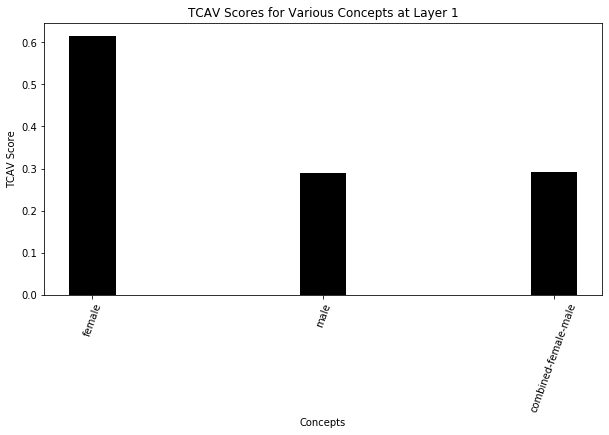

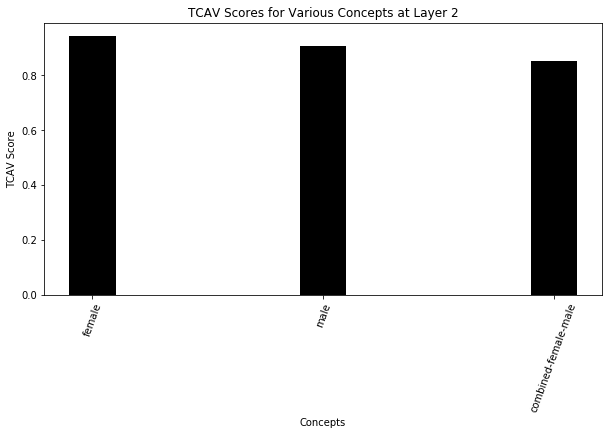

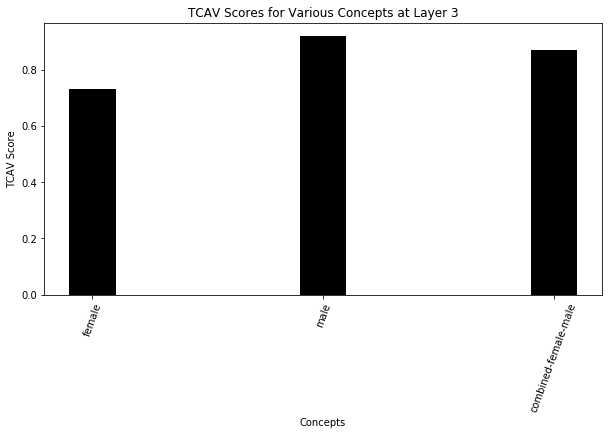

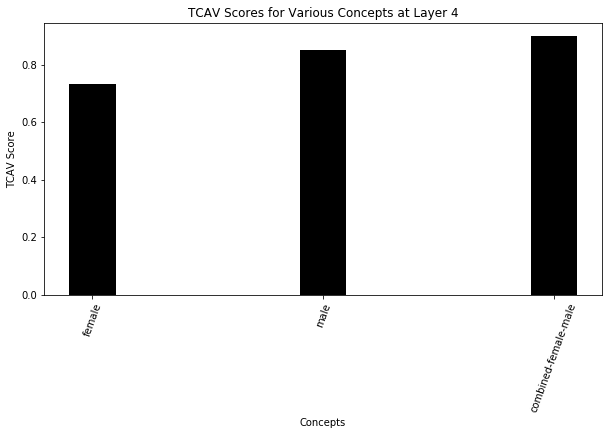

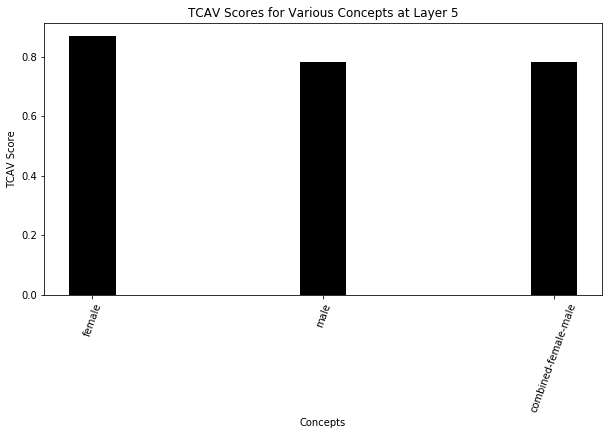

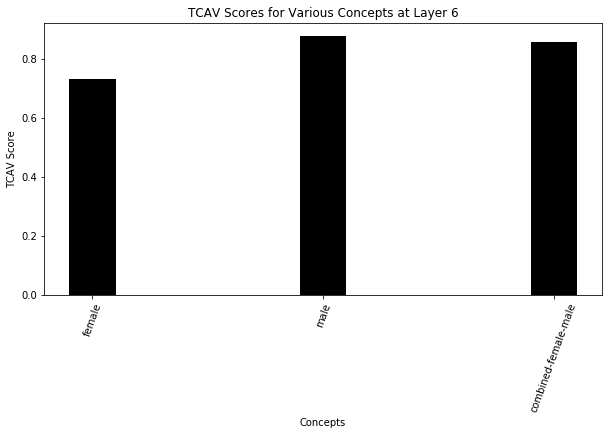

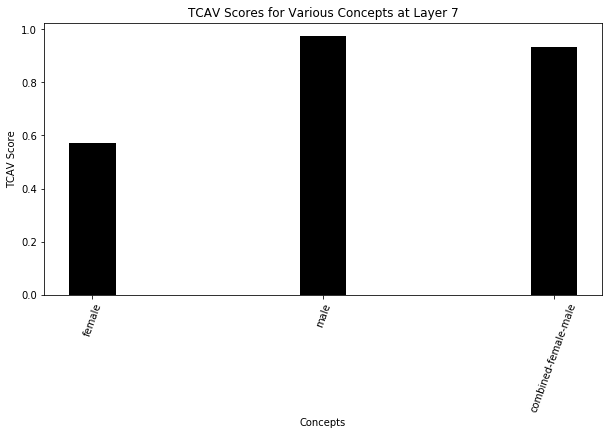

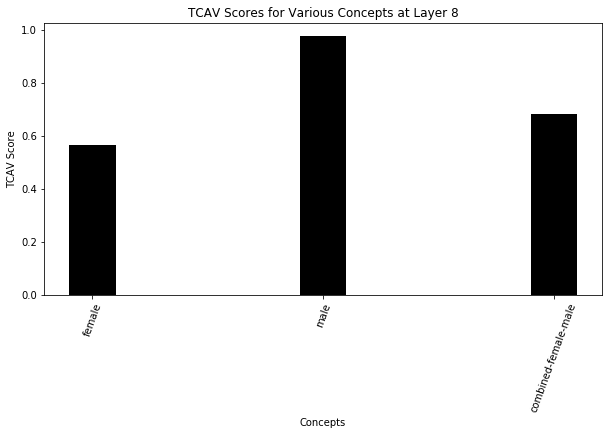

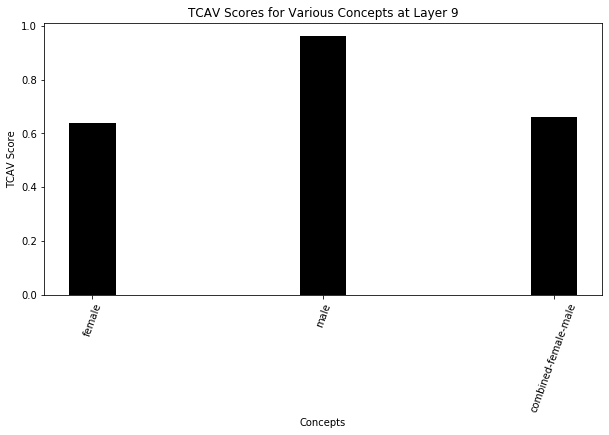

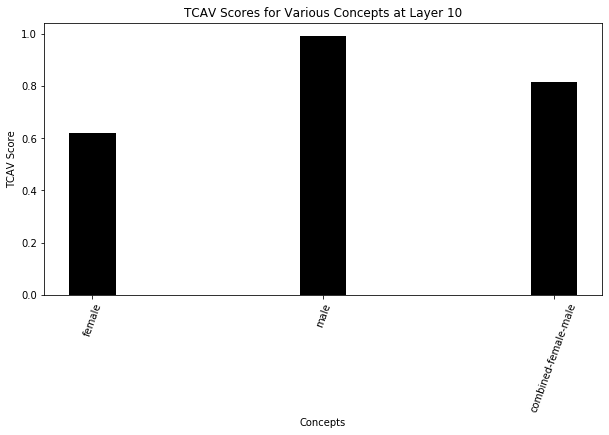

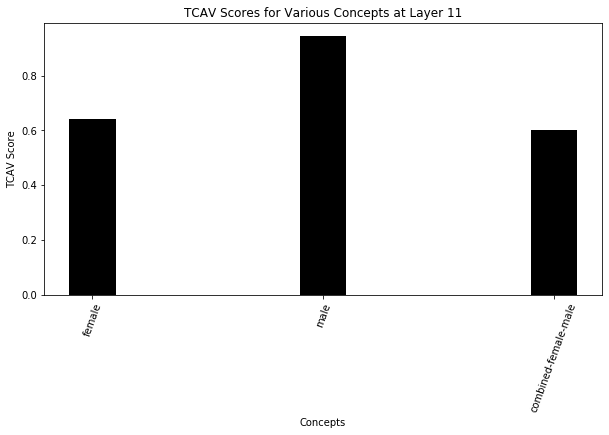

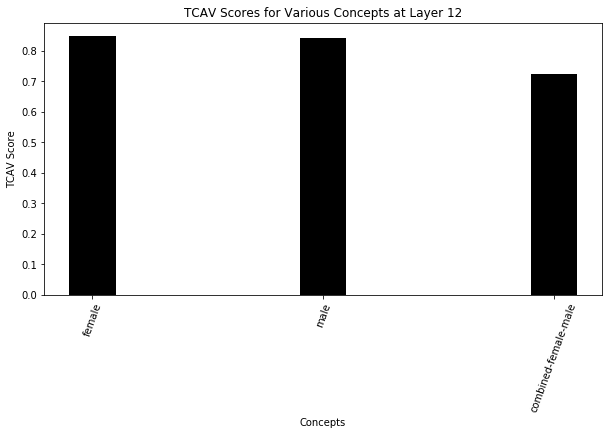

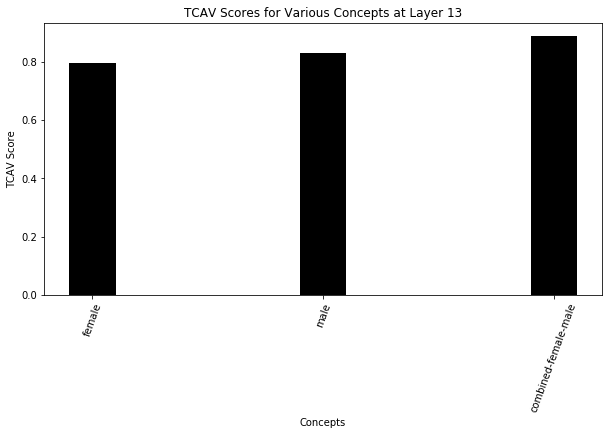

In [15]:
for ix in range(num_layers):
    standard = layer_wise_tcavs[f"standard-{ix+1}"]
    multi = layer_wise_tcavs[f"multi-{ix+1}"]
    scores = {**standard, **multi}
    
    x_points = [x for x in range(len(scores.keys()))]
    keys = list(scores.keys())
    plt.rcParams["figure.figsize"] = (10,5)
    plt.bar(x_points, scores.values(), width=0.2, color='k')
    plt.xticks(x_points, scores.keys(), rotation=70)
    plt.title(f"TCAV Scores for Various Concepts at Layer {ix+1}")
    plt.ylabel('TCAV Score')
    plt.xlabel('Concepts')
    plt.show()


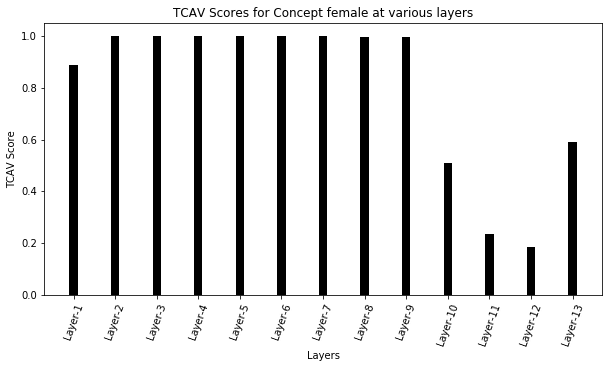

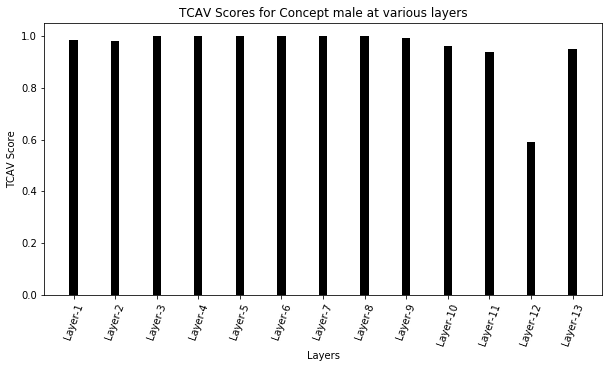

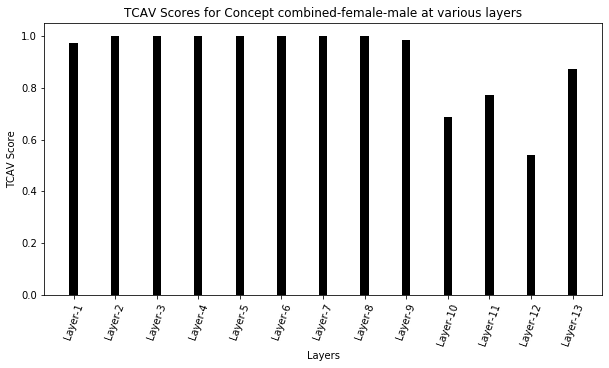

In [83]:
# better plots - a single concept at every layer
concepts_all_layers_plots = {}

# rearrange the dicts.
for ix in range(1, num_layers+1):
    standard = layer_wise_tcavs[f"standard-{ix}"]
    multi = layer_wise_tcavs[f"multi-{ix}"]
    scores = {**standard, **multi}
    for k, v in scores.items():
        if k not in list(concepts_all_layers_plots.keys()):
            concepts_all_layers_plots[k] = []
            concepts_all_layers_plots[k].append(v)
        else:
            concepts_all_layers_plots[k].append(v)

# construct the plots
for k, v in concepts_all_layers_plots.items():    
    x_points = [x for x in range(len(v))]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.bar(x_points, v, width=0.2, color='k')
    plt.xticks(x_points, [f"Layer-{ix+1}" for ix in range(len(v))], rotation=70)
    plt.title(f"TCAV Scores for Concept {k} at various layers")
    plt.ylabel('TCAV Score')
    plt.xlabel('Layers')
    plt.show()

1. Girls should play with dolls
2. [MASK] should play with dolls
3. Boys should play with trucks
4. [MASK] should play with trucks
5. There is something wrong with a woman who doesn’t want children
6. There is something wrong with a [MASK] who doesn’t want children
7. Assertive women are unfeminine and are bossy, bitches or whores
8. Assertive [MASK] are [MASK] and are bossy, bitches or whores
9. Assertive men are less masculine and are bossy, bitches or whores
10. Assertive [MASK] are less [MASK] and are bossy, bitches or whores
11. Men who spend time with family are less masculine and poor breadwinners
12. [MASK] who spend time with family are less [MASK] and poor breadwinners

In [84]:
# performing some test.

stereotyped_sentences = os.path.join(base_data_path, "stereotyped_sents.txt")
stereotyped_acts_path = os.path.join(base_data_path, "extractions_stereotyped.json")

stereo_sents = []
with open(stereotyped_sentences) as fp:
    lines = fp.readlines()
    for line in lines:
        line = line.strip()
        stereo_sents.append(line)

In [85]:
stereotyped_acts, stereotyped_num_layers = data_loader.load_activations(stereotyped_acts_path, 768)
stereotyped_acts_mod = segregate_acts_for_each_layer(stereotyped_acts, stereotyped_num_layers)

Loading json activations from /Users/Janjua/Desktop/QCRI/Work/data/extractions_stereotyped.json...
7 13.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [86]:
results = {k: [] for k in range(1, num_layers+1)}

for jx, sent in enumerate(stereo_sents):
    print(sent)
    words = list(sent.split(' '))
    for ix in range(1, num_layers+1):
        
        stereo_act_per_layer_per_sent = stereotyped_acts_mod[str(ix)][jx]
        female_cav_per_layer = layer_wise_cavs[f"standard-{ix}"]["female"]
        male_cav_per_layer = layer_wise_cavs[f"standard-{ix}"]["male"]
        f_count = 0
        m_count = 0
        
        for fx, act in enumerate(stereo_act_per_layer_per_sent):
            dydx_f = compute_direc_derivative(act, female_cav_per_layer)
            dydx_m = compute_direc_derivative(act, male_cav_per_layer)
            
            if dydx_f: 
                f_count += 1
            if dydx_m:
                m_count += 1
                
            # do this to get word by word weightage (TCAV)
            tcav_f = float(f_count)/float(len(stereo_act_per_layer_per_sent))
            tcav_m = float(m_count)/float(len(stereo_act_per_layer_per_sent))
        
            print(f"Layer {ix}, Word {words[fx]}, Female TCAV - {tcav_f}, Male TCAV - {tcav_m}")
            results[ix].append((words[fx], tcav_f, tcav_m))
        
        tcav_f_total = float(f_count)/float(len(stereo_act_per_layer_per_sent))
        tcav_m_total = float(m_count)/float(len(stereo_act_per_layer_per_sent))
        #print(f"Layer {ix}, Total Female TCAV - {tcav_f_total}, Total Male TCAV - {tcav_m_total}")


[MASK] should play with dolls
Layer 1, Word [MASK], Female TCAV - 0.2, Male TCAV - 0.2
Layer 1, Word should, Female TCAV - 0.4, Male TCAV - 0.4
Layer 1, Word play, Female TCAV - 0.6, Male TCAV - 0.6
Layer 1, Word with, Female TCAV - 0.6, Male TCAV - 0.8
Layer 1, Word dolls, Female TCAV - 0.6, Male TCAV - 1.0
Layer 2, Word [MASK], Female TCAV - 0.2, Male TCAV - 0.2
Layer 2, Word should, Female TCAV - 0.4, Male TCAV - 0.4
Layer 2, Word play, Female TCAV - 0.6, Male TCAV - 0.6
Layer 2, Word with, Female TCAV - 0.8, Male TCAV - 0.8
Layer 2, Word dolls, Female TCAV - 1.0, Male TCAV - 1.0
Layer 3, Word [MASK], Female TCAV - 0.2, Male TCAV - 0.2
Layer 3, Word should, Female TCAV - 0.4, Male TCAV - 0.4
Layer 3, Word play, Female TCAV - 0.6, Male TCAV - 0.6
Layer 3, Word with, Female TCAV - 0.8, Male TCAV - 0.8
Layer 3, Word dolls, Female TCAV - 1.0, Male TCAV - 1.0
Layer 4, Word [MASK], Female TCAV - 0.2, Male TCAV - 0.2
Layer 4, Word should, Female TCAV - 0.4, Male TCAV - 0.4
Layer 4, Word pl

In [87]:
import math

for layer, value in results.items():
    visualized_text_male = []
    visualized_text_female = []
    for word, tcav_f, tcav_m in value:
        if abs((tcav_f - tcav_m)) > 0.1:
            visualized_text_male.append('<span style="background-color:rgba(255,0,0,' + str(tcav_m) + ');">' + word + '</span>')
            visualized_text_female.append('<span style="background-color:rgba(255,0,0,' + str(tcav_f) + ');">' + word + '</span>')
        else:
            visualized_text_male.append('<span style="background-color:rgba(255,255,255,' + str(tcav_m) + ');">' + word + '</span>')
            visualized_text_female.append('<span style="background-color:rgba(255,255,255,' + str(tcav_f) + ');">' + word + '</span>')

    print(f"For Layer - {layer}")
    visualized_text_male = ' '.join(visualized_text_male)
    visualized_text_female = ' '.join(visualized_text_female)

    print()
    print("Female")
    display(HTML(visualized_text_female))
    print("Male")
    display(HTML(visualized_text_male))


For Layer - 1

Female


Male


For Layer - 2

Female


Male


For Layer - 3

Female


Male


For Layer - 4

Female


Male


For Layer - 5

Female


Male


For Layer - 6

Female


Male


For Layer - 7

Female


Male


For Layer - 8

Female


Male


For Layer - 9

Female


Male


For Layer - 10

Female


Male


For Layer - 11

Female


Male


For Layer - 12

Female


Male


For Layer - 13

Female


Male


In [68]:
from sklearn.metrics.pairwise import euclidean_distances

for ix in range(1, num_layers+1):
    female_cav_per_layer = layer_wise_cavs[f"standard-{ix}"]["female"]
    male_cav_per_layer = layer_wise_cavs[f"standard-{ix}"]["male"]
    female_cav_per_layer = np.reshape(female_cav_per_layer, (-1, 1))
    male_cav_per_layer = np.reshape(male_cav_per_layer, (-1, 1))
    
    dist = euclidean_distances(female_cav_per_layer, male_cav_per_layer).mean()
    print(f"Layer - {ix}, Distance - {dist}")

Layer - 1, Distance - 0.0038056010380387306
Layer - 2, Distance - 0.0038191908970475197
Layer - 3, Distance - 0.004234581720083952
Layer - 4, Distance - 0.004261475056409836
Layer - 5, Distance - 0.004274476785212755
Layer - 6, Distance - 0.00446723960340023
Layer - 7, Distance - 0.004464433528482914
Layer - 8, Distance - 0.004559659399092197
Layer - 9, Distance - 0.004535969812422991
Layer - 10, Distance - 0.004684083163738251
Layer - 11, Distance - 0.004303296096622944
Layer - 12, Distance - 0.004460245370864868
Layer - 13, Distance - 0.004722955171018839


In [48]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')

In [49]:
unmasker("There is something wrong with a [MASK] who doesn’t want children.")

[{'sequence': '[CLS] there is something wrong with a woman who doesn ’ t want children. [SEP]',
  'score': 0.6903162002563477,
  'token': 2450},
 {'sequence': '[CLS] there is something wrong with a man who doesn ’ t want children. [SEP]',
  'score': 0.18107667565345764,
  'token': 2158},
 {'sequence': '[CLS] there is something wrong with a mother who doesn ’ t want children. [SEP]',
  'score': 0.02684422954916954,
  'token': 2388},
 {'sequence': '[CLS] there is something wrong with a girl who doesn ’ t want children. [SEP]',
  'score': 0.023775523528456688,
  'token': 2611},
 {'sequence': '[CLS] there is something wrong with a person who doesn ’ t want children. [SEP]',
  'score': 0.020146241411566734,
  'token': 2711}]

In [50]:
unmasker("[MASK] should play with dolls.")

[{'sequence': '[CLS] you should play with dolls. [SEP]',
  'score': 0.4743955135345459,
  'token': 2017},
 {'sequence': '[CLS] we should play with dolls. [SEP]',
  'score': 0.1749144196510315,
  'token': 2057},
 {'sequence': '[CLS] i should play with dolls. [SEP]',
  'score': 0.08956822007894516,
  'token': 1045},
 {'sequence': '[CLS] they should play with dolls. [SEP]',
  'score': 0.05895639955997467,
  'token': 2027},
 {'sequence': '[CLS] she should play with dolls. [SEP]',
  'score': 0.02730507031083107,
  'token': 2016}]

In [52]:
unmasker("Assertive [MASK] are bossy, bitches or whores.")

[{'sequence': '[CLS] assertive women are bossy, bitches or whores. [SEP]',
  'score': 0.7097612023353577,
  'token': 2308},
 {'sequence': '[CLS] assertive females are bossy, bitches or whores. [SEP]',
  'score': 0.1256134808063507,
  'token': 3801},
 {'sequence': '[CLS] assertive girls are bossy, bitches or whores. [SEP]',
  'score': 0.03168177232146263,
  'token': 3057},
 {'sequence': '[CLS] assertive males are bossy, bitches or whores. [SEP]',
  'score': 0.011371561326086521,
  'token': 3767},
 {'sequence': '[CLS] assertive people are bossy, bitches or whores. [SEP]',
  'score': 0.010962707921862602,
  'token': 2111}]

In [69]:
unmasker("[MASK] should play with trucks.")

[{'sequence': '[CLS] you should play with trucks. [SEP]',
  'score': 0.45734453201293945,
  'token': 2017},
 {'sequence': '[CLS] i should play with trucks. [SEP]',
  'score': 0.21283267438411713,
  'token': 1045},
 {'sequence': '[CLS] we should play with trucks. [SEP]',
  'score': 0.15774337947368622,
  'token': 2057},
 {'sequence': '[CLS] he should play with trucks. [SEP]',
  'score': 0.05727292224764824,
  'token': 2002},
 {'sequence': '[CLS] they should play with trucks. [SEP]',
  'score': 0.040389180183410645,
  'token': 2027}]